# Day 7：入门级模型（概念体验，不求深）

> 今日目标：理解“用特征预测标签”的基本流程；跑通 1 个线性回归 + 1 个简单分类；会看基础评估指标；知道模型局限。

学习路径：
1. 机器学习最小流程概念
2. 准备数据与特征构造 (lag / 简单派生)
3. 回归：预测 PM2.5 (线性回归)
4. 分类：判断是否为高污染日 (二分类)
5. 评估指标 (R² / MAE / Accuracy)
6. 过拟合直观认识 & 基线对比
7. 模型解释初步 (系数)
8. 小结
9. 课后作业提示

## 1. 机器学习最小流程概念
一句话：用历史“特征”学习一个函数 f(x)≈y，再用来预测新样本。

流程 6 步：
1. 明确任务（回归 or 分类）
2. 准备数据（清洗 / 选取列 / 构造特征）
3. 划分训练集 / 测试集 (train_test_split)
4. 训练：fit
5. 评估：在测试集上算指标
6. 解释 & 复盘：是否有效？是否存在风险？

今日我们不追求算法全面，只体验流水线。

## 2. 准备数据与特征
使用 Day 4/5 的 `air_quality_timeseries.csv`。我们构造：
- 特征：同日 PM10 / NO2 / SO2 + 前一日 PM25 (lag1)
- 目标 (回归)：当日 PM25
- 目标 (分类)：高污染标签 high_flag (PM25 > 55 记为 1) (阈值仅演示)

Lag 处理：按 city + date 排序，向下平移 1 行。首行会缺失 → 丢弃。

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report

df = pd.read_csv('../data/air_quality_timeseries.csv', parse_dates=['date'])
df.head()

,date,city,province,PM25,PM10,NO2,SO2
0,2025-09-01,广州,广东,42,55,19,7
1,2025-09-02,广州,广东,41,54,18,7
2,2025-09-03,广州,广东,39,50,17,6
3,2025-09-04,广州,广东,45,57,20,7
4,2025-09-05,广州,广东,44,56,19,7


In [2]:
# 按城市 + 日期排序，并创建 lag1 特征
df = df.sort_values(['city','date']).copy()
df['PM25_lag1'] = df.groupby('city')['PM25'].shift(1)
# 分类标签
df['high_flag'] = (df['PM25'] > 55).astype(int)
df.head(8)

,date,city,province,PM25,PM10,NO2,SO2,PM25_lag1,high_flag
10,2025-09-01,上海,上海,45,62,28,10,NaN,0
11,2025-09-02,上海,上海,47,63,29,10,45.0,0
12,2025-09-03,上海,上海,43,60,27,9,47.0,0
13,2025-09-04,上海,上海,46,61,28,10,43.0,0
14,2025-09-05,上海,上海,44,59,27,9,46.0,0
5,2025-09-01,北京,北京,60,80,35,12,NaN,1
6,2025-09-02,北京,北京,65,85,37,13,60.0,1
7,2025-09-03,北京,北京,58,78,34,11,65.0,1


In [3]:
# 丢弃 lag 缺失行
model_df = df.dropna(subset=['PM25_lag1']).copy()
print('原始行数:', df.shape[0], ' 可用行数:', model_df.shape[0])
model_df.head()

原始行数: 30  可用行数: 24


,date,city,province,PM25,PM10,NO2,SO2,PM25_lag1,high_flag
11,2025-09-02,上海,上海,47,63,29,10,45.0,0
12,2025-09-03,上海,上海,43,60,27,9,47.0,0
13,2025-09-04,上海,上海,46,61,28,10,43.0,0
14,2025-09-05,上海,上海,44,59,27,9,46.0,0
6,2025-09-02,北京,北京,65,85,37,13,60.0,1


### 小练习 1
1. 思考还有哪些简单可加特征？(例如 PM 差值：PM10-PM25)
2. 尝试新增列 PM_diff = PM10 - PM25 并查看是否与 PM25 有相关。

## 3. 回归：线性回归预测 PM2.5
目标：预测 `PM25`。特征：PM10, NO2, SO2, PM25_lag1。
评估：R²（越接近 1 越好）+ MAE（越小越好）。
基线思路：如果总是预测训练集均值，MAE 大概多少？(可作为对照)。

In [4]:
features = ['PM10','NO2','SO2','PM25_lag1']
X = model_df[features]
y = model_df['PM25']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('R^2:', round(r2,3))
print('MAE:', round(mae,2))
# 基线：用训练集均值预测
baseline = np.full_like(y_test, fill_value=y_train.mean())
mae_baseline = mean_absolute_error(y_test, baseline)
print('基线 MAE (预测均值):', round(mae_baseline,2))

R^2: 0.982
MAE: 0.58
基线 MAE (预测均值): 11.62


### 解释：
- 如果模型 MAE 比基线显著降低 → 说明利用特征有效。
- R² 负值说明模型比“直接用均值”还差。

## 4. 分类：高污染日判别 (Logistic Regression)
标签：high_flag = 1 (PM25>55)。特征可与回归相同。
评估：Accuracy。说明：数据量少 → 结果仅演示。

In [5]:
X_class = model_df[features]
y_class = model_df['high_flag']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)
clf = LogisticRegression(max_iter=500)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)
acc = accuracy_score(yc_test, yc_pred)
print('Accuracy:', round(acc,3))
print('分类报告:')
print(classification_report(yc_test, yc_pred, digits=3))

Accuracy: 1.0
分类报告:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000         3

    accuracy                          1.000         8
   macro avg      1.000     1.000     1.000         8
weighted avg      1.000     1.000     1.000         8



注意：若标签极不平衡，Accuracy 可能失真。以后需看 Precision / Recall / F1。课程限于入门，仅展示概念。

### 小练习 2
1. 改变划分 random_state 看结果是否稳定。
2. 若全部预测 0，Accuracy 约是多少？(计算标签占比)

## 5. 模型系数 (线性回归 & Logistic)
系数方向：正 → 特征增大，预测值增大；负 → 反向。大小受量纲影响→ 正规做法需标准化 (本课略)。

In [6]:
coef_table = pd.DataFrame({
    'feature': features,
    'linear_coef': reg.coef_,
    'logistic_coef': clf.coef_[0]
})
coef_table

,feature,linear_coef,logistic_coef
0,PM10,1.006991,1.052641
1,NO2,-0.486596,-0.095853
2,SO2,0.304548,-0.194290
3,PM25_lag1,-0.083326,-0.180256


### 解释提示：
- 仅在所有其他特征固定时的线性近似影响。
- 不代表因果关系。
- 多特征相关时系数不稳定。

## 6. 过拟合直观认识
过拟合：模型在训练集表现很好，在测试集差。今天用的线性模型偏简单，不易严重过拟合。
概念记住即可：需要平衡“拟合能力”与“泛化能力”。

### 小练习 3
1. 尝试只用 PM25_lag1 作为唯一特征再训练回归，比较 MAE。
2. 思考：简单模型结果与多特征相比差多少？是否值得引入更多复杂特征？

## 7. 快速可视化：真实 vs 预测 (回归)
仅用于直观感受。

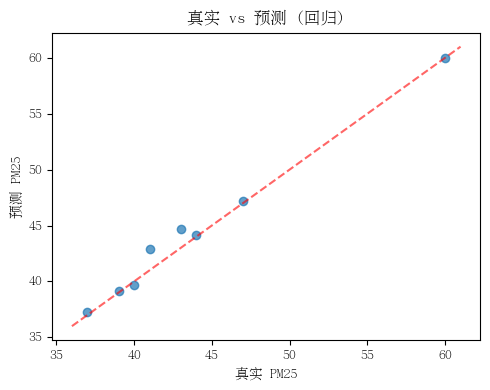

In [10]:
import matplotlib.pyplot as plt
# 修复中文显示与负号问题
plt.rcParams['font.sans-serif'] = ['AR PL UMing CN']  # 若无 SimHei，可改为 ['Arial Unicode MS'] 或系统中文字体
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('真实 PM25')
plt.ylabel('预测 PM25')
plt.title('真实 vs 预测 (回归)')
# 参考 y=x 线
lims = [min(y_test.min(), y_pred.min())-1, max(y_test.max(), y_pred.max())+1]
plt.plot(lims, lims, 'r--', alpha=0.6)
plt.tight_layout()
plt.show()

### 小练习 4
1. 计算预测残差 (y_test - y_pred) 的平均值与标准差。
2. 观察是否存在系统性偏差 (平均值显著非 0)。

## 8. 小结
流程核心：特征准备 → 划分训练/测试 → 训练 (fit) → 评估 (R²/MAE/Accuracy) → 解释/复盘。 

今日要点：
1. 构造时间相关特征：lag (按分组 shift) 是时序常用基线做法。
2. 回归评估双视角：误差 (MAE) + 拟合度 (R²)；与“预测均值”基线比较判断是否有价值。
3. 分类起步看 Accuracy，同时意识到类别不平衡隐患。
4. 系数只表相关方向与线性近似，不等于因果；特征相关性会影响稳定性。
5. 过拟合概念：训练好/测试差；简单线性模型示例中尚不突出，但需保有警觉。 

实践提示：
- 先做“无模型”基线（均值 / 频率），再上模型验证增益。
- 固定 random_state 保障可复现；保留特征列表以便快速做 ablation（删减对比）。

展望：Day 8 综合项目中，若加入模型务必注明：数据范围、特征来源、阈值假设与局限。

In [8]:
# 模型进阶代码示例 (基线 + 残差 + 交叉验证)
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv('../data/air_quality_timeseries.csv', parse_dates=['date']).sort_values(['city','date'])
df['PM25_lag1'] = df.groupby('city')['PM25'].shift(1)
model_df = df.dropna(subset=['PM25_lag1']).copy()
X = model_df[['PM10','NO2','SO2','PM25_lag1']]
y = model_df['PM25']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
reg = LinearRegression().fit(X_train,y_train)
pred = reg.predict(X_test)
mae = mean_absolute_error(y_test,pred); r2 = r2_score(y_test,pred)
print('MAE:', round(mae,2),' R2:', round(r2,3))

# 1. 中位数基线
baseline_med = np.full_like(y_test, fill_value=np.median(y_train))
print('中位数基线 MAE:', round(mean_absolute_error(y_test, baseline_med),2))

# 2. 残差分析
residuals = y_test - pred
print('残差均值≈0?', round(residuals.mean(),3),'  标准差:', round(residuals.std(),2))

# 3. 简单交叉验证 (仅演示, 用全数据)
scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=3)
print('CV MAE 平均:', round(-scores.mean(),2))

MAE: 0.58  R2: 0.982
中位数基线 MAE: 13.12
残差均值≈0? -0.506   标准差: 0.81
CV MAE 平均: 0.95


### 模型进阶与良好实践（入门视角）
1. 随机种子：保证实验可复现 (random_state)。
2. 基线多样化：回归可用中位数预测；分类可用多数类预测。
3. 特征重要性：线性模型系数需标准化后再对比；树模型 (后续) 可看 feature_importances_。
4. 数据泄漏警惕：不能用未来信息（如同日平均后再预测）。
5. 评估切分：后续可用交叉验证 cross_val_score。
6. 管道思想：Pipeline 封装预处理 + 模型，防止数据泄漏。
7. 残差分析：残差 vs 预测值分布是否随机；系统模式提示欠拟合/非线性。
8. 过拟合症状：训练指标显著好于测试；加入正则化可改善。
9. 指标多角度：回归( MAE / RMSE / R² )；分类(Accuracy + Precision/Recall/F1)。
10. 记录实验：表格化 (特征集/参数/指标) 便于比较。

## 9. 课后作业提示
提交 *homework_day7.ipynb*：
1. 自行再增加 1 个特征 (如 PM10 - PM25)，重新训练回归并记录 MAE 与 R² 变化。
2. 再做一次分类：修改阈值为 60，对比 Accuracy 有何变化。
3. 将回归训练封装成函数 train_simple_reg(df, feature_list) 返回 (r2, mae)。调用两次比较。
4. 写 120 字：说明你今天模型的局限（数据量、特征、评估方式、潜在偏差）。
(可选) 5. 把线性回归预测结果按误差绝对值排序，列出误差最大的 3 条记录并猜测原因。

---
📌 提示：明天 Day 8 综合实践可选择是否加入“简单模型”一节，务必明确说明假设与局限。